## Model training

In this notebook I tried different models, compare their performance, try to optimize hyperparameters.
I used the accuracy metric for evaluation
Training part of this notebook is converted to the script

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import os
import shutil
from tensorflow.keras.layers import Dense, Input, Flatten,  Conv2D, MaxPooling2D

## Prepare dataset
As this dataset is too large, and it's takes too much time to train model's - I've added next script to cut dataset to 100 images per each font and store them in ../data/processed folder

In [2]:
src_folder = '../data/raw/Font Dataset Large/'
dest_folder = '../data/processed'
num_files = 100

def copy_files(src_folder, dest_folder, num_files):
    if os.path.exists(dest_folder) and os.path.isdir(dest_folder):
        shutil.rmtree(dest_folder)
    for dir_name in os.listdir(src_folder):
        dir_path = os.path.join(src_folder, dir_name)
        if os.path.isdir(dir_path):
            files = os.listdir(dir_path)
            jpg_files = [file for file in files if file.endswith('.jpg')]
            jpg_files_to_copy = jpg_files[:num_files]
            dest_dir = os.path.join(dest_folder, dir_name)
            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir)

            for file_name in jpg_files_to_copy:
                shutil.copy(os.path.join(dir_path, file_name), dest_dir)


copy_files(src_folder, dest_folder, num_files)

## Data generators

Let's add augumentation to ImageDataGenerator

In [23]:
datagen = ImageDataGenerator(
                            #  rotation_range = 20,
                             brightness_range=[0.2, 1.0],
                            #  zoom_range = 0.2,
                            #  shear_range = 0.15,
                            #  horizontal_flip = True,
                             rescale = 1./255,
                             validation_split = 0.2)

In [24]:
IMG_SIZE = 224
NUM_COLOR_BITS = 3
BATCH_SIZE = 32
NUM_CLASSES = 48
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)

data_dir = dest_folder

train_generator = datagen.flow_from_directory(data_dir,
                                           target_size = TARGET_SIZE,
                                           batch_size = BATCH_SIZE,
                                           subset = "training",
                                           class_mode = "categorical")
valid_generator = datagen.flow_from_directory(data_dir,
                                       target_size = TARGET_SIZE,
                                       batch_size = BATCH_SIZE,
                                       subset = "validation",
                                       class_mode = 'categorical')

Found 3840 images belonging to 48 classes.
Found 960 images belonging to 48 classes.


## Transfer learning
I've decided to test different models, also simple CNN was aded

In [5]:
def get_base_model(model_name: str, model_input_shape):
    if model_name == "simple_cnn_model":
        base_model = tf.keras.models.Sequential()
        base_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=model_input_shape))
        base_model.add(MaxPooling2D((2, 2)))
        base_model.add(Conv2D(64, (3, 3), activation='relu'))
        base_model.add(MaxPooling2D((2, 2)))
        base_model.add(Conv2D(128, (3, 3), activation='relu'))
        base_model.add(MaxPooling2D((2, 2)))
    else:
        MODELS = {
            "vgg16": VGG16,
            "vgg19": VGG19,
            "inception": InceptionV3,
            "xception": Xception,
            "resnet": ResNet50
        }
        base_model = MODELS[model_name]
        base_model = base_model(include_top=False, weights="imagenet", input_shape = model_input_shape)
        base_model.trainable = False

    
    return base_model

In [6]:
def get_model(model_name, model_input_shape, num_classes):
    inputs = Input(shape=model_input_shape)

    base_model = get_base_model(model_name, model_input_shape)

    if model_name != 'simple_cnn_model':
        model = tf.keras.Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(num_classes, activation="softmax"))
    else:
        x = Flatten()(base_model(inputs))
        x = Dense(128, activation='relu')(x)
    
        outputs = Dense(num_classes, activation="softmax")(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

## vgg16 model

In [7]:
model = get_model('vgg16', (IMG_SIZE, IMG_SIZE, NUM_COLOR_BITS), NUM_CLASSES)
model.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=['accuracy'])

# model.summary()

In [27]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.1,
                              patience = 2, 
                              min_lr=0.00001,
                              verbose = 1)


class stopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.95):
            print("\nReached 95% accuracy - stopping training")
            self.model.stop_training = True


callbacks = [
    stopTrainingCallback(),
    # tf.keras.callbacks.ModelCheckpoint(
    #     "vgg16_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
    #     monitor="val_accuracy",
    #     save_best_only=True,
    #     mode='max'
    # )
]

epochs = 10
history = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_data = valid_generator,
                    validation_steps = valid_generator.samples//BATCH_SIZE,
                    callbacks = [reduce_lr, callbacks],
                    verbose = 1)

Epoch 1/10
 19/120 [===>..........................] - ETA: 4:23 - loss: 0.8928 - accuracy: 0.7516

KeyboardInterrupt: 

In [9]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

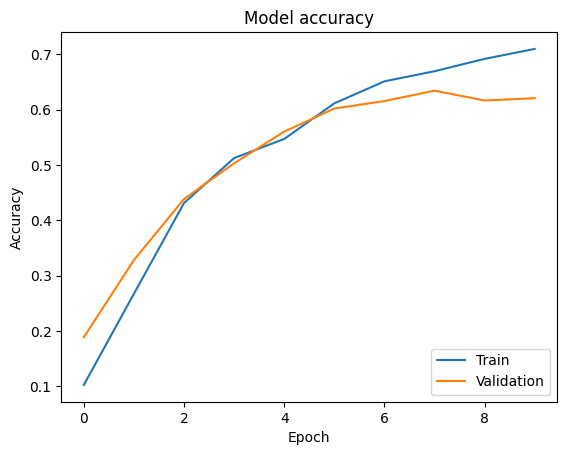

In [10]:
plot_history(history)

In [11]:
model.save('../artifacts/vgg16_model.h5')

/home/vscode/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
def get_label_by_class(id):
    mapping = {
        0: 'Agency',
        1: 'Akzidenz Grotesk',
        2: 'Algerian',
        3: 'Arial',
        4: 'Baskerville',
        5: 'Bell MT',
        6: 'Bembo',
        7: 'Bodoni',
        8: 'Book Antiqua',
        9: 'Brandish',
        10: 'Calibry',
        11: 'Californian FB',
        12: 'Calligraphy',
        13: 'Calvin',
        14: 'Cambria',
        15: 'Candara',
        16: 'Century',
        17: 'Comic Sans MS',
        18: 'Consolas',
        19: 'Corbel',
        20: 'Courier',
        21: 'Didot',
        22: 'Elephant',
        23: 'Fascinate',
        24: 'Franklin Gothic',
        25: 'Futigre',
        26: 'Futura',
        27: 'Garamond',
        28: 'Georgia',
        29: 'Gill Sans',
        30: 'Helvetica',
        31: 'Hombre',
        32: 'Lato',
        33: 'LCD Mono',
        34: 'Lucida Bright', 
        35: 'Monotype Corsiva',
        36: 'Mrs Eaves',
        37: 'Myriad',
        38: 'Nasalization',
        39: 'News Gothic',
        40: 'Palatino linotype',
        41: 'Perpetua',
        42: 'Rockwell',
        43: 'Sabon',
        44: 'Snowdrift Regular',
        45: 'Steppes',
        46: 'Times New Roman',
        47: 'Verdana'
    }
    
    return mapping.get(id)

In [13]:
def predict_class(path, target_size):
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    predicts = model.predict(x)

    return np.argmax(predicts[0])

In [14]:
path_to_test_image = os.path.join(src_folder, 'Arial', 'Image_48.jpg')
predicted_class = predict_class(path_to_test_image, TARGET_SIZE)
print(f"Result class: {predicted_class}, label: {get_label_by_class(predicted_class)}")

1/1 [==============================] - 0s 248ms/step
Result class: 3, label: Arial


## Inception model

In [15]:
model_inception = get_model('inception', (IMG_SIZE, IMG_SIZE, NUM_COLOR_BITS), NUM_CLASSES)
model_inception.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=['accuracy'])

In [16]:
history_inception = model_inception.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_data = valid_generator,
                    validation_steps = valid_generator.samples//BATCH_SIZE,
                    callbacks = [stopTrainingCallback()],
                    verbose = 1)

Epoch 1/10
120/120 [==============================] - 156s 1s/step - loss: 6.4331 - accuracy: 0.0589 - val_loss: 3.6776 - val_accuracy: 0.0750
Epoch 2/10
120/120 [==============================] - 151s 1s/step - loss: 3.6424 - accuracy: 0.0747 - val_loss: 3.6477 - val_accuracy: 0.0844
Epoch 3/10
120/120 [==============================] - 153s 1s/step - loss: 3.5213 - accuracy: 0.1042 - val_loss: 3.4621 - val_accuracy: 0.1385
Epoch 4/10
120/120 [==============================] - 155s 1s/step - loss: 3.3860 - accuracy: 0.1500 - val_loss: 3.3072 - val_accuracy: 0.1542
Epoch 5/10
120/120 [==============================] - 120s 994ms/step - loss: 3.2622 - accuracy: 0.1599 - val_loss: 3.2172 - val_accuracy: 0.1625
Epoch 6/10
120/120 [==============================] - 117s 974ms/step - loss: 3.1752 - accuracy: 0.1703 - val_loss: 3.1635 - val_accuracy: 0.1729
Epoch 7/10
120/120 [==============================] - 113s 937ms/step - loss: 3.0926 - accuracy: 0.1859 - val_loss: 3.0737 - val_accurac

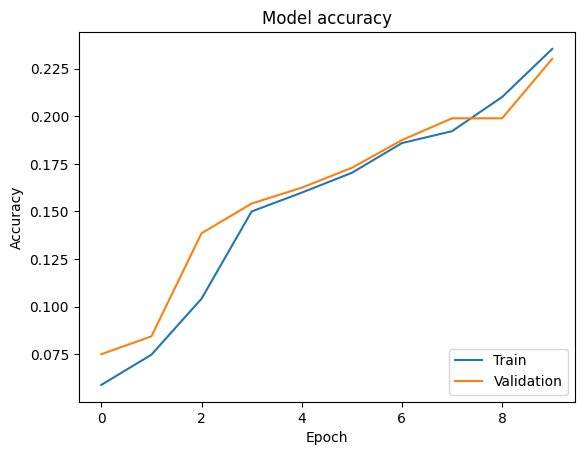

In [17]:
plot_history(history_inception)

In [18]:
model.save('../artifacts/inception_model.h5')

## Simple CNN model

In [19]:
model_simple_cnn = get_model('simple_cnn_model', (IMG_SIZE, IMG_SIZE, NUM_COLOR_BITS), NUM_CLASSES)
model_simple_cnn.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=['accuracy'])

In [20]:
history_simple_cnn = model_simple_cnn.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_data = valid_generator,
                    validation_steps = valid_generator.samples//BATCH_SIZE,
                    callbacks = [stopTrainingCallback()],
                    verbose = 1)

Epoch 1/10
120/120 [==============================] - 130s 1s/step - loss: 3.7424 - accuracy: 0.0458 - val_loss: 3.2790 - val_accuracy: 0.0865
Epoch 2/10
120/120 [==============================] - 138s 1s/step - loss: 2.8210 - accuracy: 0.2013 - val_loss: 2.4410 - val_accuracy: 0.2969
Epoch 3/10
120/120 [==============================] - 140s 1s/step - loss: 2.3030 - accuracy: 0.3117 - val_loss: 2.4317 - val_accuracy: 0.2677
Epoch 4/10
120/120 [==============================] - 142s 1s/step - loss: 2.0619 - accuracy: 0.3570 - val_loss: 2.0463 - val_accuracy: 0.3750
Epoch 5/10
120/120 [==============================] - 141s 1s/step - loss: 1.8871 - accuracy: 0.4036 - val_loss: 1.9999 - val_accuracy: 0.3615
Epoch 6/10
120/120 [==============================] - 143s 1s/step - loss: 1.7400 - accuracy: 0.4526 - val_loss: 1.7350 - val_accuracy: 0.4688
Epoch 7/10
120/120 [==============================] - 142s 1s/step - loss: 1.6248 - accuracy: 0.4781 - val_loss: 1.7546 - val_accuracy: 0.4250

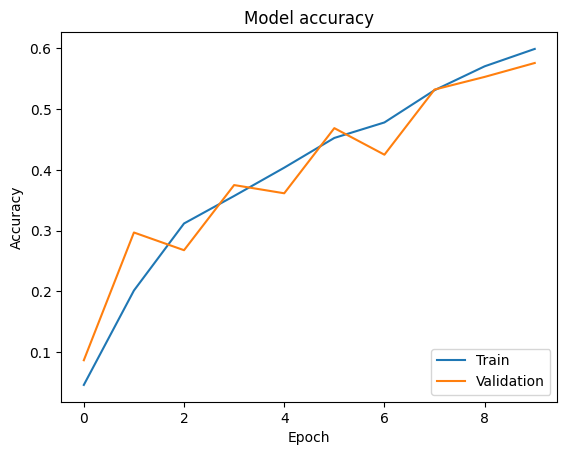

In [21]:
plot_history(history_simple_cnn)

In [22]:
model.save('../artifacts/simple_cnn_model.h5')

## Results
According to my tests, I'll chose vgg16 model because it gives best results

## Conclusion
- In this notebook I've tried different models for Transfer learning
- Optimized hyperparameters
- Compared results of different models results (using accuracy)
- Select the best model (vgg16)

What can be done:
- Check/compare other models, which present in list
- Try to change augumentation and compare results
- Train models on full dataset to get better accuracy